<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center>Introduction to Anomaly Detection in Time Series with Keras</h2>


## Project Overview and Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)

C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (

## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [13]:
df = pd.read_csv('S&P_500_Index_Data.csv')
df.head()

,date,close
0,02-Jan-86,209.59
1,03-Jan-86,210.88
2,06-Jan-86,210.65
3,07-Jan-86,213.80
4,08-Jan-86,207.97


In [14]:
df.shape

(8192, 2)

In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close,
                    mode='lines',
                    name='close'))
fig.update_layout(showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [27]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)
print(test_size)

(6553, 2) (1639, 2)
1639


In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

## Task 4: Create Training and Test Splits

In [29]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [30]:
time_steps = 30

X_train, y_train = create_dataset(train[['close']], train.close, time_steps)
X_test, y_test = create_dataset(test[['close']], test.close, time_steps)

print(X_train.shape)

(6523, 30, 1)


## Task 5: Build an LSTM Autoencoder

In [31]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

## Task 6: Train the Autoencoder

In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Train on 5870 samples, validate on 653 samples
Epoch 1/100
5870/5870 [==============================] - 19s 3ms/sample - loss: 0.1625 - val_loss: 0.1610
Epoch 2/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.1114 - val_loss: 0.0986
Epoch 3/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0903 - val_loss: 0.0443
Epoch 4/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0802 - val_loss: 0.0442
Epoch 5/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0717 - val_loss: 0.0618
Epoch 6/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0774 - val_loss: 0.0326
Epoch 7/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0751 - val_loss: 0.0309
Epoch 8/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0745 - val_loss: 0.0590
Epoch 9/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0759 - val_loss: 0.0528

## Task 7: Plot Metrics and Evaluate the Model

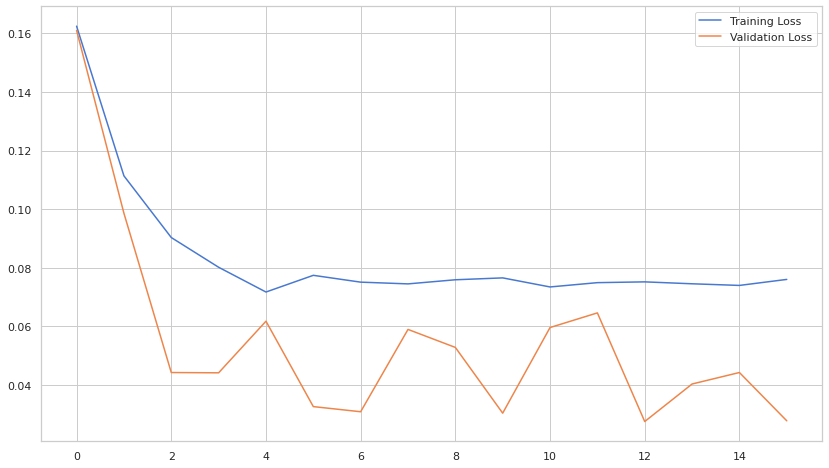

In [14]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [15]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [16]:
model.evaluate(X_test, y_test)

1609/1609 [==============================] - 2s 972us/sample - loss: 0.2708


0.270815260740746

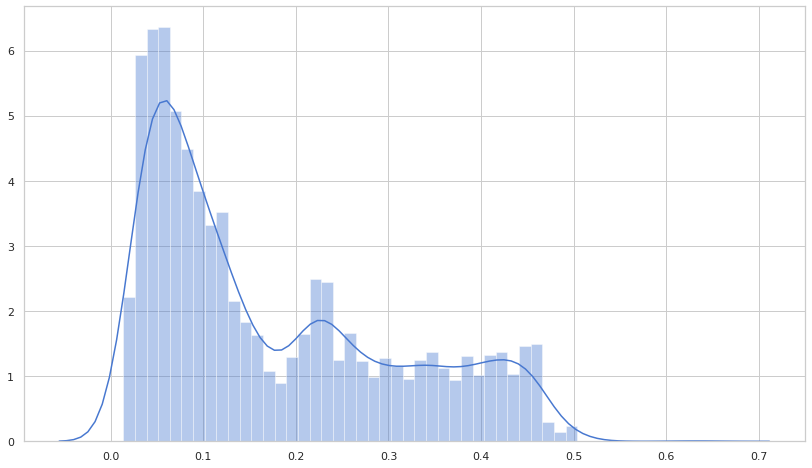

In [17]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [18]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

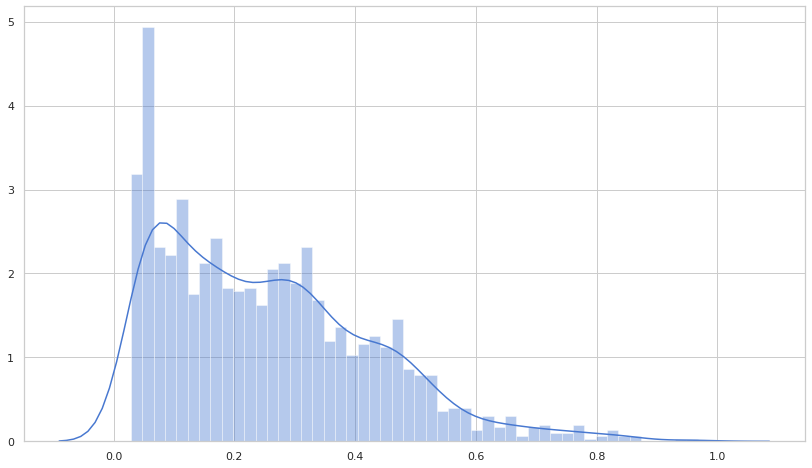

In [19]:
sns.distplot(test_mae_loss, bins=50, kde=True);

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [20]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [22]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.655632,0.65,True
7475,2015-08-26,2.632149,0.711593,0.65,True
8090,2018-02-05,4.329949,0.665444,0.65,True
8091,2018-02-06,4.440671,0.853328,0.65,True
8092,2018-02-07,4.408365,0.829433,0.65,True


In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()